In case you are running this notebook in Colab! If you want to enable GPU acceleration, ensure you select a GPU runtime in the top-right dropdown menu 🚀

# Training ML potentials using GNNs

> **FYI**, you can open this documentation as a [Google Colab notebook](https://colab.research.google.com/github/omidshy/ml-notebooks/blob/master/notebooks/graph-pes-water.ipynb) to follow along interactively

For more information on the ``graph-pes-train`` command, and the plethora of options available for specification in your ``config.yaml`` see the [CLI reference](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train/root.html).

Below, we train a [MACE](https://jla-gardner.github.io/graph-pes/models/many-body/mace.html) model on a dataset containing ... structures of liquid water.

We should have access to the ``graph-pes-train`` command. We can check this by running:

In [1]:
!graph-pes-train -h

/bin/bash: line 1: graph-pes-train: command not found


## Reference Data 

We use [load-atoms](https://jla-gardner.github.io/load-atoms/) to load a local dataset and split the dataset into training, validation and test datasets:

In [2]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("../data/water.xyz")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-water.xyz", train)
ase.io.write("val-water.xyz", val)
ase.io.write("test-water.xyz", test)

We can visualise the kinds of structures we're training on using [load_atoms.view](https://jla-gardner.github.io/load-atoms/api/viz.html):


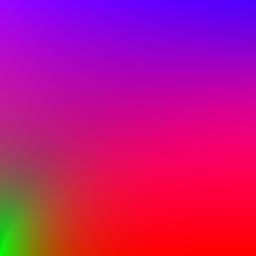

In [3]:
from load_atoms import view

view(train[0], show_bonds=True)

As you can see, each structure has an energy label:

In [4]:
train[0].info["energy"]

-59902.224159998004

... as well as a forces label (one for each atom in the structure):

In [5]:
train[0].arrays["forces"].shape

(384, 3)

These properties are stored in the files we have just created:

In [7]:
!head train-water.xyz

384
Lattice="15.6458 0.0 0.0 0.0 15.6458 0.0 0.0 0.0 15.6458" Properties=species:S:1:pos:R:3:forces:R:3 energy=-59902.224159998004 pbc="T T T"
O       28.41529458      46.63446554      37.32941023      -0.83396096      -0.85760007       0.84091246
O       33.83556377      51.11551814      34.73008678      -1.04999455      -0.03230609       1.50307228
O       43.00926410      58.67941646      34.59988871       0.50557559       0.71004199       1.66908050
O       31.92148843      50.03776109      29.64631459      -0.75320788       0.51452035      -0.41228878
O       31.80371488      60.14223499      16.78079075      -0.01994384       0.30644458       0.45407310
O       26.05130067      61.31547097      24.32778356      -1.59924028      -1.13453158      -1.67300969
O       39.18542494      60.99831503      20.25635681       1.02087813       0.50703825       0.00048805
O       36.23603581      62.39006798      20.01307849      -0.18173584       1.33887172       0.52662386


## Configuration

Great - now lets train a model. To do this, we have specified the following in our ``water.yaml`` file:

* the model architecture to instantiate and train, here [MACE](https://jla-gardner.github.io/graph-pes/models/many-body/mace.html). Note that we also include a [FixedOffset](https://jla-gardner.github.io/graph-pes/models/offsets.html#graph_pes.models.FixedOffset) component to account for the fact that the energy labels have an arbitrary energy offset.
* the data to train on, here the liquid water dataset we just loaded
* the loss function to use, here a combination of a per-atom energy loss and a per-atom force loss
* and various other training hyperparameters (e.g. the learning rate, batch size, etc.)



We can download [this config file](https://raw.githubusercontent.com/omidshy/ml-notebooks/refs/heads/master/data/quickstart-cgap17.yaml) using wget:

In [8]:
%%bash

if [ ! -f water.yaml ]; then
    wget https://tinyurl.com/water-config -O water.yaml
fi

--2025-10-07 12:46:07--  https://tinyurl.com/quickstart-config
Resolving tinyurl.com (tinyurl.com)... 2606:4700::6811:70e9, 2606:4700::6812:6fa1, 104.18.111.161, ...
Connecting to tinyurl.com (tinyurl.com)|2606:4700::6811:70e9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/omidshy/ml-notebooks/refs/heads/master/data/quickstart-cgap17.yaml [following]
--2025-10-07 12:46:08--  https://raw.githubusercontent.com/omidshy/ml-notebooks/refs/heads/master/data/quickstart-cgap17.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362 (1.3K) [text/plain]
Saving to: ‘quickstart-cgap17.yaml’

     0K .                                                     100%  102M=0s

2025-10-

## Training

We use the downloaded config file to start the training.


In [ ]:
!graph-pes-train water.yaml general/run_id=train-mace-water

## Model Analysis

As part of the `graph-pes-train` run, the model was tested on the test set we specified in the config file (see the final section of the logs above).

To analyse the model in more detail, we first need to load it from disk. You can see from the command we used, and the training logs above, that the best model from the training run (i.e. the set of weights that gave the lowest validation loss) has been saved as `graph-pes-results/train-mace-water/model.pt`.

Let's load that best model, put it on the GPU for accelerated inference if available, and get it ready for evaluation:

In [ ]:
import torch
from graph_pes.models import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = (
    load_model("graph-pes-results/train-mace/model.pt")  # load the model
    .to(device)  # move to GPU if available
    .eval()  # set to evaluation mode
)

The easiest way to use our model is to use the [GraphPESCalculator](https://jla-gardner.github.io/graph-pes/tools/ase.html#graph_pes.utils.calculator.GraphPESCalculator) to act directly on [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects:

In [ ]:
calculator = best_model.ase_calculator()
calculator.calculate(test[0], properties=["energy", "forces"])
calculator.results

We can see from a single data point that our model has done a reasonable job of learning the PES:

In [ ]:
calculator.get_potential_energy(test[0]), test[0].info["energy"]

... and predicting the atomic forces:

In [ ]:
calculator.get_forces(test[0])[1], test[0].arrays["forces"][1]

``graph-pes`` provides a few utility functions for visualising model performance:

In [ ]:
import matplotlib.pyplot as plt
from graph_pes.utils.analysis import parity_plot

%config InlineBackend.figure_format = 'retina'

parity_plot(
    best_model,
    test,
    property="energy_per_atom",
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson",
)
plt.xlim(-158.5, -155)
plt.ylim(-158.5, -155);

In [ ]:
parity_plot(
    best_model,
    test,
    property="forces",
    units="eV / Å",
    lw=0,
    s=2,
    alpha=0.5,
    color="crimson",
)

In [ ]:
from graph_pes.utils.analysis import dimer_curve

dimer_curve(best_model, system="CC", units="eV", rmin=0.85, rmax=4.0);

## Dynamics Simulation

Running molecular dynamics (MD) with our trained model is straightforward.

Below, we use ASE-driven MD for simplicity - please see the [LAMMPS MD guide](https://jla-gardner.github.io/graph-pes/tools/lammps.html) for instructions on how to run MD with our model in LAMMPS.

In [ ]:
from ase import units
from ase.md.langevin import Langevin

# set up structure
structure = ase.io.read("test-water.xyz", index=0)

# set up MD
structure.calc = calculator
dynamics = Langevin(
    structure,
    timestep=0.1 * units.fs,
    temperature_K=300,
    friction=0.01 / units.fs,
)
dynamics.attach(
    lambda: structure.write("traj-water.xyz", append=True),
    interval=10,
)

# run MD
dynamics.run(1000) # 1000 steps = 0.1 ps

In [ ]:
view(structure, show_bonds=True)

In [ ]:
trajectory = ase.io.read("traj-water.xyz", index=":")
view(trajectory[100], show_bonds=True)